### Libraries used



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/NLP

/content/drive/MyDrive/NLP


In [3]:
ls

AppReview-Multilabel.csv  cc.ar.300.vec


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [5]:
# Set seed
SEED = 777

### Loading data

In [6]:
# Load dataset
df = pd.read_csv("AppReview-Multilabel.csv")
df.head()

,review,bug_report,improvement_request,rating,others
0,يبيله تصليحات كثير,High,Medium,Low,No
1,ماتحملت ابدددددا ونا دفعت فلوس 🤔😕,No,Medium,Medium,Low
2,اتمنى منكم عمل خيار لتفضيل المسلسل بالكامل عوض...,No,High,Low,No
3,ممتاز وبسيط وتشغيله لا يؤثر على سرعة الانترنت,No,No,High,No
4,تبين م لي ي تم ل يب,No,No,Low,High


In [ ]:
print(df.describe())

              review bug_report improvement_request rating others
count           2900       2900                2900   2900   2900
unique          2892          4                   4      4      4
top     اكثر من رائع         No                  No   High     No
freq               3       1736                1797    988   2080


## Part-B: Multiclass App Review Classification: from scratch



#### B.1 Lable distribution

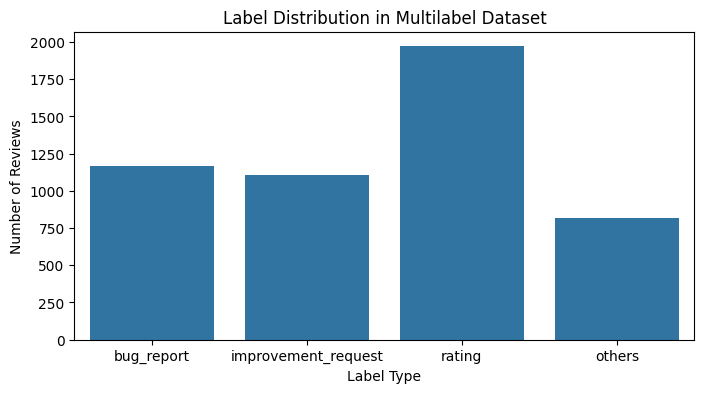

In [ ]:
# Count non-"No" values to estimate multilabel counts
class_cols = ['bug_report', 'improvement_request', 'rating', 'others']
label_counts = {}

for col in class_cols:
    label_counts[col] = (df[col] != "No").sum()

# Plot label distribution
plt.figure(figsize=(8, 4))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()))
plt.title("Label Distribution in Multilabel Dataset")
plt.ylabel("Number of Reviews")
plt.xlabel("Label Type")
plt.show()


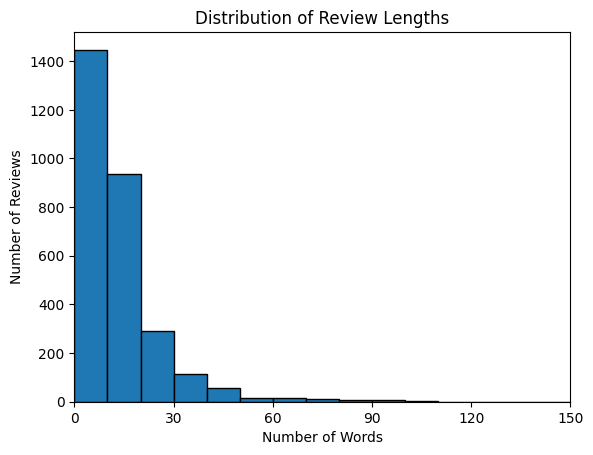


Average Review Length: 13.551724137931034


In [ ]:
df['review_length'] = df['review'].apply(lambda x: len(str(x).split()))


plt.hist(df['review_length'], bins=range(0, 151, 10), edgecolor="black")  # Adjust bins for better granularity
plt.title("Distribution of Review Lengths")
plt.xlim(0, 150)  # Set x-axis range
plt.xticks(range(0, 151, 30))  # Adjust tick marks
plt.xlabel("Number of Words")
plt.ylabel("Number of Reviews")
plt.show()

print("\nAverage Review Length:", df['review_length'].mean())



#### B.2 Conversion to multiclass

In [7]:
def assign_single_label(row):
    if row['bug_report'] != 'No':
        return 'bug_report'
    elif row['improvement_request'] != 'No':
        return 'improvement_request'
    elif row['rating'] != 'No':
        return 'rating'
    else:
        return 'others'

df['label'] = df.apply(assign_single_label, axis=1)
df['label'].value_counts()


,count
label,
bug_report,1164
rating,944
improvement_request,595
others,197


#### B.3 Text preprocessing

In [8]:
def preprocess_arabic(text):
    text = str(text)
    # Normalize Arabic characters
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)

    # Remove diacritics
    text = re.sub(r'[\u064B-\u0652]', '', text)

    # Remove repeated characters
    text = re.sub(r'(.)\1+', r'\1\1', text) # kept 2 since some arabic words actually have two repeating letters

    # Remove non-Arabic letters and digits
    text = re.sub(r'[^\u0600-\u06FF\s]', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Apply preprocessing
df['cleaned_review'] = df['review'].apply(preprocess_arabic)
df[['review', 'cleaned_review']].head()

,review,cleaned_review
0,يبيله تصليحات كثير,يبيله تصليحات كثير
1,ماتحملت ابدددددا ونا دفعت فلوس 🤔😕,ماتحملت ابددا ونا دفعت فلوس
2,اتمنى منكم عمل خيار لتفضيل المسلسل بالكامل عوض...,اتمني منكم عمل خيار لتفضيل المسلسل بالكامل عوض...
3,ممتاز وبسيط وتشغيله لا يؤثر على سرعة الانترنت,ممتاز وبسيط وتشغيله لا يوثر علي سرعه الانترنت
4,تبين م لي ي تم ل يب,تبين م لي ي تم ل يب


#### B.4 Label encoding

In [9]:
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# For reference
label_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_map)

Label Mapping: {'bug_report': np.int64(0), 'improvement_request': np.int64(1), 'others': np.int64(2), 'rating': np.int64(3)}


#### B.5 Data splitting

In [10]:
# First: Train-Test Split (80-20)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=df['label_encoded'])

# Second: Validation Split from Train (15% of train)
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=SEED, stratify=train_df['label_encoded'])

# Show sizes
print(f"Training Samples: {len(train_df)}")
print(f"Validation Samples: {len(val_df)}")
print(f"Testing Samples: {len(test_df)}")

Training Samples: 1972
Validation Samples: 348
Testing Samples: 580


#### B.6 Tokeniation and padding

In [11]:
# Set parameters
MAX_NUM_WORDS = 10000  # top N words to keep
MAX_SEQUENCE_LENGTH = 120  # max words per review

# Tokenize
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['cleaned_review'])

# Convert to sequences
X_train_seq = tokenizer.texts_to_sequences(train_df['cleaned_review'])
X_val_seq = tokenizer.texts_to_sequences(val_df['cleaned_review'])
X_test_seq = tokenizer.texts_to_sequences(test_df['cleaned_review'])

# Pad sequences
X_train = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_val = pad_sequences(X_val_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_test = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [12]:
# One-hot encode labels
y_train = to_categorical(train_df['label_encoded'])
y_val = to_categorical(val_df['label_encoded'])
y_test = to_categorical(test_df['label_encoded'])

In [13]:
word_index = tokenizer.word_index
print(f"Vocabulary size: {len(word_index)}")

Vocabulary size: 8319


#### B.7 Building LSTM model

In [33]:
def plot_history(histories, labels, metric='accuracy'):
    plt.figure(figsize=(8, 6))
    for history, label in zip(histories, labels):
        plt.plot(history.history[metric], label=f"{label} - train")
        plt.plot(history.history[f"val_{metric}"], linestyle='--', label=f"{label} - val")
    plt.title(f"{metric.capitalize()} Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid()
    plt.show()

##### B.7.1 LSTM with random embedding

In [24]:
# Parameters
EMBEDDING_DIM_RANDOM = 100  # can be smaller
NUM_CLASSES = y_train.shape[1]

model_random = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS,
              output_dim=EMBEDDING_DIM_RANDOM,
              input_length=MAX_SEQUENCE_LENGTH,
              trainable=True),  # learn embeddings during training
    LSTM(128),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(NUM_CLASSES, activation='softmax')
])

model_random.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_random.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

##### B.7.2 LSTM with pretrained embedding

In [25]:
# Load pretrained FastText embeddings
embedding_index = {}
with open("cc.ar.300.vec", encoding='utf-8') as f:
    next(f)  # skip header
    for line in f:
        values = line.rstrip().split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

print(f"Loaded {len(embedding_index)} word vectors.")

# Build embedding matrix
EMBEDDING_DIM_PRETRAINED = 300
embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM_PRETRAINED))

for word, i in tokenizer.word_index.items():
    if i < MAX_NUM_WORDS:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Model 2: Use precomputed FastText vectors
model_pretrained = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS,
              output_dim=EMBEDDING_DIM_PRETRAINED,
              weights=[embedding_matrix],
              input_length=MAX_SEQUENCE_LENGTH,
              trainable=False),  # freeze embeddings
    LSTM(128),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(NUM_CLASSES, activation='softmax')
])

model_pretrained.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_pretrained.summary()


Loaded 2000000 word vectors.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,000,000 (11.44 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,000,000 (11.44 MB)

#### B.8 Model training

In [26]:
EPOCHS = 20
BATCH_SIZE = 32

In [27]:
# Train model 1
print("Training Model with Random Embeddings...\n")
history_random = model_random.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Training Model with Random Embeddings...

Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 214ms/step - accuracy: 0.3677 - loss: 1.2968 - val_accuracy: 0.4023 - val_loss: 1.2481
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 215ms/step - accuracy: 0.3674 - loss: 1.2481 - val_accuracy: 0.4023 - val_loss: 1.2494
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 209ms/step - accuracy: 0.3947 - loss: 1.2493 - val_accuracy: 0.4023 - val_loss: 1.2495
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 209ms/step - accuracy: 0.3933 - loss: 1.2459 - val_accuracy: 0.4023 - val_loss: 1.2458
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 210ms/step - accuracy: 0.4140 - loss: 1.2391 - val_accuracy: 0.4023 - val_loss: 1.2411
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 210ms/step - accuracy: 0.3953 - loss: 1.2366 - val_accuracy: 0.4023 - val_loss: 1.2427
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 196ms/step - accuracy: 0.4041 - loss: 1.2380 - val_accuracy: 0.4023 - val_loss: 1.2446
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 211ms/step - 

In [28]:
# Train model 2
print("Training Model with Pretrained FastText Embeddings...\n")
history_pretrained = model_pretrained.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)


Training Model with Pretrained FastText Embeddings...

Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 18s 237ms/step - accuracy: 0.4031 - loss: 1.3089 - val_accuracy: 0.4023 - val_loss: 1.2428
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 228ms/step - accuracy: 0.3910 - loss: 1.2553 - val_accuracy: 0.3994 - val_loss: 1.2724
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 230ms/step - accuracy: 0.3772 - loss: 1.2466 - val_accuracy: 0.4023 - val_loss: 1.2412
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 220ms/step - accuracy: 0.3845 - loss: 1.2574 - val_accuracy: 0.4023 - val_loss: 1.2408
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 224ms/step - accuracy: 0.4013 - loss: 1.2379 - val_accuracy: 0.4023 - val_loss: 1.2414
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 222ms/step - accuracy: 0.4124 - loss: 1.2400 - val_accuracy: 0.4023 - val_loss: 1.2408
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 223ms/step - accuracy: 0.4026 - loss: 1.2513 - val_accuracy: 0.4023 - val_loss: 1.2412
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 14s 

In [29]:
loss_random, accuracy_random = model_random.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (Random Embeddings): {loss_random:.4f}")
print(f"Test Accuracy (Random Embeddings): {accuracy_random:.4f}")

Test Loss (Random Embeddings): 1.2420
Test Accuracy (Random Embeddings): 0.4017


In [30]:
loss_pretrained, accuracy_pretrained = model_pretrained.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (Pretrained Embeddings): {loss_pretrained:.4f}")
print(f"Test Accuracy (Pretrained Embeddings): {accuracy_pretrained:.4f}")

Test Loss (Pretrained Embeddings): 1.2384
Test Accuracy (Pretrained Embeddings): 0.4017


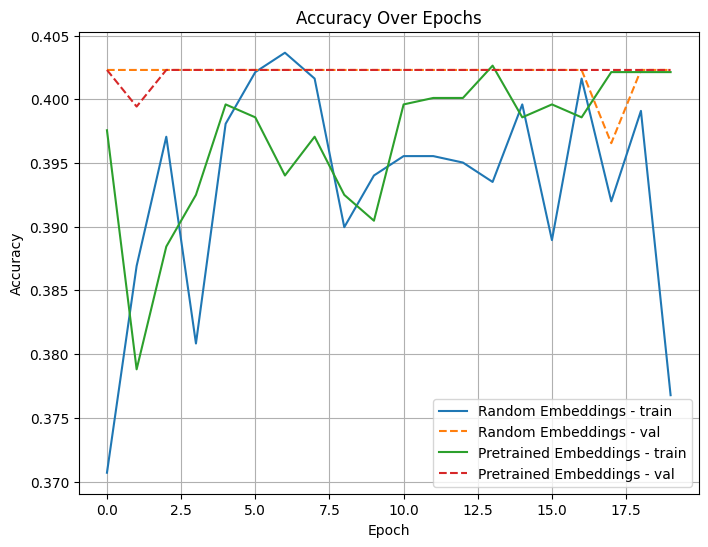

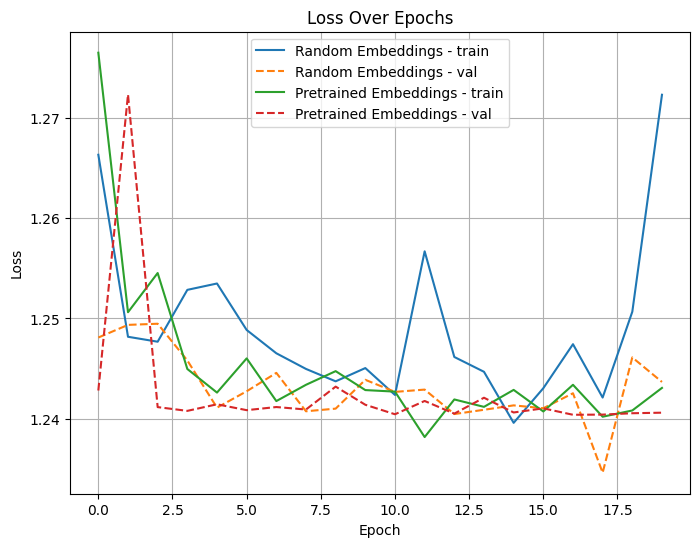

In [32]:
plot_history(
    [history_random, history_pretrained],
    ["Random Embeddings", "Pretrained Embeddings"],
    metric='accuracy'
)

plot_history(
    [history_random, history_pretrained],
    ["Random Embeddings", "Pretrained Embeddings"],
    metric='loss'
)

#### B.9 Classification analysis and possible improvements.

##### B.9.1 Applying oversampling

In [14]:
# Combine features and labels
train_df_combined = train_df[['cleaned_review', 'label_encoded']]

# Separate by class
classes = train_df_combined['label_encoded'].unique()
class_dfs = [train_df_combined[train_df_combined['label_encoded'] == c] for c in classes]

# Find the class with max samples
max_len = max([len(df) for df in class_dfs])

# Oversample minority classes
resampled_dfs = [
    resample(df, replace=True, n_samples=max_len, random_state=SEED)
    if len(df) < max_len else df
    for df in class_dfs
]

# Concatenate back
balanced_train_df = pd.concat(resampled_dfs).sample(frac=1, random_state=SEED)  # shuffle

print("Balanced class counts:")
print(balanced_train_df['label_encoded'].value_counts())

Balanced class counts:
label_encoded
2    791
1    791
3    791
0    791
Name: count, dtype: int64


In [15]:
# Tokenize balanced data
X_train_balanced_seq = tokenizer.texts_to_sequences(balanced_train_df['cleaned_review'])
X_train_balanced = pad_sequences(X_train_balanced_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

# Labels
y_train_balanced = to_categorical(balanced_train_df['label_encoded'])

##### B.9.2 Modifying the model to use (Oversampled data, BiLSTM, Callback functions)

In [20]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

In [21]:
EMBEDDING_DIM_RANDOM = 100
NUM_CLASSES = y_train.shape[1]

model_os_random = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS,
              output_dim=EMBEDDING_DIM_RANDOM,
              input_length=MAX_SEQUENCE_LENGTH,
              trainable=True),
    Bidirectional(LSTM(128)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation='softmax')
])

model_os_random.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_os_random.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [34]:
EMBEDDING_DIM_PRETRAINED = 300

model_os_pretrained = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS,
              output_dim=EMBEDDING_DIM_PRETRAINED,
              weights=[embedding_matrix],
              input_length=MAX_SEQUENCE_LENGTH,
              trainable=False),
    Bidirectional(LSTM(128)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation='softmax')
])

model_os_pretrained.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_os_pretrained.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,000,000 (11.44 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,000,000 (11.44 MB)

In [35]:
EPOCHS = 7
BATCH_SIZE = 32

In [36]:
# Train model with Random Embeddings
print("Training BiLSTM with Random Embeddings...\n")
history_os_random = model_os_random.fit(
    X_train_balanced, y_train_balanced,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)

Training BiLSTM with Random Embeddings...

Epoch 1/7
99/99 ━━━━━━━━━━━━━━━━━━━━ 45s 400ms/step - accuracy: 0.3080 - loss: 1.3453 - val_accuracy: 0.4799 - val_loss: 1.1396 - learning_rate: 0.0010
Epoch 2/7
99/99 ━━━━━━━━━━━━━━━━━━━━ 39s 395ms/step - accuracy: 0.7432 - loss: 0.6015 - val_accuracy: 0.6523 - val_loss: 1.0672 - learning_rate: 0.0010
Epoch 3/7
99/99 ━━━━━━━━━━━━━━━━━━━━ 38s 364ms/step - accuracy: 0.9531 - loss: 0.1603 - val_accuracy: 0.6580 - val_loss: 1.3420 - learning_rate: 0.0010
Epoch 4/7
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.9835 - loss: 0.0516
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
99/99 ━━━━━━━━━━━━━━━━━━━━ 42s 370ms/step - accuracy: 0.9835 - loss: 0.0518 - val_accuracy: 0.6408 - val_loss: 1.3654 - learning_rate: 0.0010
Epoch 5/7
99/99 ━━━━━━━━━━━━━━━━━━━━ 38s 377ms/step - accuracy: 0.9957 - loss: 0.0271 - val_accuracy: 0.6379 - val_loss: 1.7533 - learning_rate: 5.0000e-04
Epoch 5: early stopping
Restoring model we

In [37]:
# Evaluate the model with random embeddings on the test data
loss_os_random, accuracy_os_random = model_os_random.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (Random Embeddings): {loss_os_random:.4f}")
print(f"Test Accuracy (Random Embeddings): {accuracy_os_random:.4f}")


Test Loss (Random Embeddings): 0.9587
Test Accuracy (Random Embeddings): 0.6810


In [38]:
# Train model with Pretrained FastText Embeddings
print("Training BiLSTM with Pretrained FastText Embeddings...\n")
history_os_pretrained = model_os_pretrained.fit(
    X_train_balanced, y_train_balanced,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)

Training BiLSTM with Pretrained FastText Embeddings...

Epoch 1/7
99/99 ━━━━━━━━━━━━━━━━━━━━ 51s 459ms/step - accuracy: 0.3691 - loss: 1.3148 - val_accuracy: 0.5948 - val_loss: 1.1098 - learning_rate: 0.0010
Epoch 2/7
99/99 ━━━━━━━━━━━━━━━━━━━━ 76s 403ms/step - accuracy: 0.6455 - loss: 0.9386 - val_accuracy: 0.6322 - val_loss: 0.9182 - learning_rate: 0.0010
Epoch 3/7
99/99 ━━━━━━━━━━━━━━━━━━━━ 40s 390ms/step - accuracy: 0.7352 - loss: 0.7176 - val_accuracy: 0.6437 - val_loss: 0.8242 - learning_rate: 0.0010
Epoch 4/7
99/99 ━━━━━━━━━━━━━━━━━━━━ 42s 399ms/step - accuracy: 0.7933 - loss: 0.5903 - val_accuracy: 0.6609 - val_loss: 0.8534 - learning_rate: 0.0010
Epoch 5/7
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.8240 - loss: 0.5065
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
99/99 ━━━━━━━━━━━━━━━━━━━━ 41s 394ms/step - accuracy: 0.8240 - loss: 0.5065 - val_accuracy: 0.6580 - val_loss: 0.8653 - learning_rate: 0.0010
Epoch 6/7
99/99 ━━━━━━━━━━━━━━━━━

In [39]:
# Evaluate the model with pretrained embeddings on the test data
loss_os_pretrained, accuracy_os_pretrained = model_os_pretrained.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (Pretrained Embeddings): {loss_os_pretrained:.4f}")
print(f"Test Accuracy (Pretrained Embeddings): {accuracy_os_pretrained:.4f}")

Test Loss (Pretrained Embeddings): 0.8606
Test Accuracy (Pretrained Embeddings): 0.6724


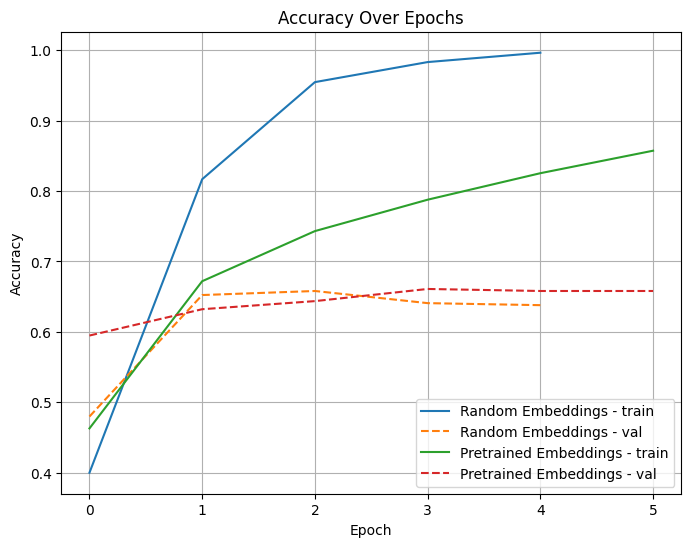

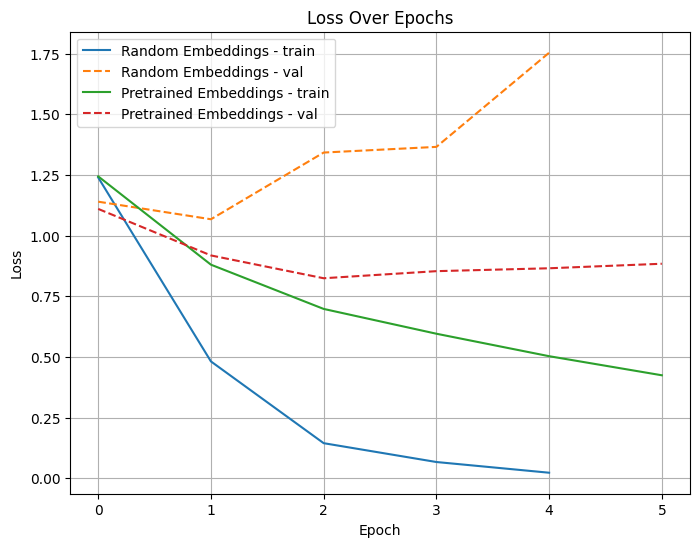

In [40]:
plot_history(
    [history_os_random, history_os_pretrained],
    ["Random Embeddings", "Pretrained Embeddings"],
    metric='accuracy'
)

plot_history(
    [history_os_random, history_os_pretrained],
    ["Random Embeddings", "Pretrained Embeddings"],
    metric='loss'
)

## Part-C: Multilabel App Review Classification: from scratch

## Part-D: Multiclass App Review Classification: Finetune an MLM

## Part-E: Multilabel App Review Classification: Finetune an MLM

## Part-F: Multiclass App Review Classification: In-Context learning using causal LLM


#### Zero-shot learning

#### Few-shot learning

## Part-G: Multilabel App Review Classification: In-Context learning using causal LLM


#### Zero-shot learning

#### Few-shot learning